<a href="https://colab.research.google.com/github/ClaudiaMarano/Anomaly-Detection-and-Prediction/blob/main/networkDenseNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Questo è il task di prediction del progetto di Anomaly-Detection-and-Prediction relativo alla parte di Network. Il metodo su cui si basa questo task è quello basato sull'utilizzo di Dense NN


Pipeline per il preprocessing dei dati
--------------------------------------
IMPORTANTE
--------------------------------------
Ad ogni runtime aggiungere nuovamente i file csv in una cartella chiamata csv, non è possibile caricare tutti i csv poichè troppo pesanti

In [35]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Funzione per controllare differenze nelle feature tra i file CSV
def check_feature_differences(file_paths):
    feature_sets = []

    for file in file_paths:
        try:
            df = pd.read_csv(file, nrows=1)  # Legge solo la prima riga per ottenere le feature
            df.columns = df.columns.str.strip()  # Rimuove spazi dai nomi delle colonne
            feature_sets.append(set(df.columns))
        except Exception as e:
            print(f"Errore durante la lettura del file {file}: {e}")

    # Confronta le feature tra i file
    common_features = set.intersection(*feature_sets)  # Feature comuni a tutti i file
    unique_features = [features - common_features for features in feature_sets]  # Feature uniche per file

    # Output dei risultati
    result = {
        "common_features": common_features,
        "unique_features_per_file": {
            os.path.basename(file): unique for file, unique in zip(file_paths, unique_features)
        }
    }

    return result

# Funzione per unire i file CSV
def merge_csv_files(file_paths):
    dataframes = []

    for file in file_paths:
        try:
            df = pd.read_csv(file)
            df.columns = df.columns.str.strip()  # Rimuove spazi dai nomi delle colonne
            dataframes.append(df)
        except pd.errors.EmptyDataError:
            print(f"File vuoto: {file}")
        except pd.errors.ParserError as e:
            print(f"Errore di parsing nel file {file}: {e}")
        except Exception as e:
            print(f"Errore sconosciuto durante la lettura del file {file}: {e}")

    try:
        combined_df = pd.concat(dataframes, ignore_index=True)
        print(f"Unione completata. Numero totale di righe: {combined_df.shape[0]}")
        return combined_df
    except ValueError as e:
        print(f"Errore durante l'unione dei file: {e}")
        return pd.DataFrame()

# Funzione per analizzare le feature e identificare quelle inutili
def analyze_features(df):
    try:
        # Calcolo del numero di valori unici per ogni colonna
        unique_counts = df.nunique()

        # Identificazione di feature con valori mancanti
        missing_values = df.isna().sum()

        # Identificazione di feature con valori costanti
        constant_features = [col for col in df.columns if unique_counts[col] == 1]

        # Report
        print("Analisi delle feature:")
        print("Numero di valori unici per feature:")
        print(unique_counts)
        print("Valori mancanti per feature:")
        print(missing_values)
        print("Feature con valori costanti:")
        print(constant_features)
    except Exception as e:
        print(f"Errore durante l'analisi delle feature: {e}")

# Funzione per rimuovere la feature 'label'
def remove_label_feature(df):
    try:
        if 'label' in df.columns:
            df = df.drop(columns=['label'])
            print("Feature 'label' rimossa con successo.")
        else:
            print("Feature 'label' non trovata nel dataset.")
        return df
    except Exception as e:
        print(f"Errore durante la rimozione della feature 'label': {e}")
        return df

# Funzione per rimuovere la feature 'modbus_response'
def remove_modbus_response_feature(df):
    try:
        if 'modbus_response' in df.columns:
            df = df.drop(columns=['modbus_response'])
            print("Feature 'modbus_response' rimossa con successo.")
        else:
            print("Feature 'modbus_response' non trovata nel dataset.")
        return df
    except Exception as e:
        print(f"Errore durante la rimozione della feature 'modbus_response': {e}")
        return df


# Funzione per rimuovere la feature 'modbus_fn'
def remove_modbus_fn_feature(df):
    try:
        if 'modbus_fn' in df.columns:
            df = df.drop(columns=['modbus_fn'])
            print("Feature 'modbus_fn' rimossa con successo.")
        else:
            print("Feature 'modbus_fn' non trovata nel dataset.")
        return df
    except Exception as e:
        print(f"Errore durante la rimozione della feature 'modbus_fn': {e}")
        return df

# Funzione per riempire i valori mancanti e preservare le anomalie
def handle_missing_values(df, target_column):
    try:
        # Separare le righe con anomalie
        anomalies = df[df[target_column] == 1]
        non_anomalies = df[df[target_column] != 1]

        # Riempire i valori mancanti con la mediana nei dati numerici senza anomalie
        non_anomalies = non_anomalies.fillna(non_anomalies.median(numeric_only=True))

        # Riempire i valori mancanti categoriali con un valore predefinito ('unknown')
        categorical_columns = non_anomalies.select_dtypes(include=['object']).columns
        for col in categorical_columns:
            non_anomalies[col] = non_anomalies[col].fillna('unknown')

        # Riempire eventuali valori mancanti residui nelle anomalie
        anomalies = anomalies.fillna(non_anomalies.median(numeric_only=True))
        for col in categorical_columns:
            anomalies[col] = anomalies[col].fillna('unknown')

        # Concatenare di nuovo i dataset
        df = pd.concat([non_anomalies, anomalies], ignore_index=True)

        print("Valori mancanti gestiti con successo. Tutte le righe sono state preservate.")
        return df
    except Exception as e:
        print(f"Errore durante la gestione dei valori mancanti: {e}")
        return df


# Funzione per eliminare i valori mancanti dal dataset
def drop_missing_values(df):
    try:
        initial_shape = df.shape
        df = df.dropna()
        print(f"Valori mancanti eliminati. Dimensione iniziale: {initial_shape}, Dimensione dopo eliminazione: {df.shape}.")
        return df
    except Exception as e:
        print(f"Errore durante l'eliminazione dei valori mancanti: {e}")
        return df

# Funzione per normalizzare le feature numeriche
def normalize_numeric_features(df, numeric_features):
    try:
        scaler = MinMaxScaler()
        df[numeric_features] = scaler.fit_transform(df[numeric_features])
        print("Feature numeriche normalizzate con successo.")
        return df
    except Exception as e:
        print(f"Errore durante la normalizzazione delle feature numeriche: {e}")
        return df

# Funzione per codificare le feature categoriali
def encode_categorical_features(df, categorical_features):
    try:
        encoder = LabelEncoder()
        for feature in categorical_features:
            if feature in df.columns:
                df[feature] = encoder.fit_transform(df[feature].astype(str))
        print("Feature categoriali codificate con successo.")
        return df
    except Exception as e:
        print(f"Errore durante la codifica delle feature categoriali: {e}")
        return df

# Funzione per verificare la presenza di anomalie nella colonna target
def check_for_anomalies(df, target_column):
    try:
        if target_column in df.columns:
            anomaly_count = df[target_column].value_counts().get(1, 0)
            print(f"Numero di anomalie (valore 1) nella colonna '{target_column}': {anomaly_count}")
            return anomaly_count > 0
        else:
            print(f"Colonna '{target_column}' non trovata nel dataset.")
            return False
    except Exception as e:
        print(f"Errore durante il controllo delle anomalie: {e}")
        return False

# Directory del dataset Network
dataset_path = "./csv"
network_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.csv')]

# Controllo delle differenze nelle feature tra i file
feature_differences = check_feature_differences(network_files)

# Output dei risultati
print("Feature comuni a tutti i file:")
print(feature_differences["common_features"])

print("Feature uniche per ciascun file:")
for file, unique_features in feature_differences["unique_features_per_file"].items():
    print(f"File: {file}")
    print(f"Feature uniche: {unique_features}")

# Unione dei file CSV
combined_dataset = merge_csv_files(network_files)

# Analisi delle feature
analyze_features(combined_dataset)

anomalie = check_for_anomalies(combined_dataset, target_column='label_n')

# Rimozione della feature 'label'
combined_dataset = remove_label_feature(combined_dataset)

# Rimozione della feature 'modbus_response'
combined_dataset = remove_modbus_response_feature(combined_dataset)

# Rimozione della feature 'modbus_fn'
combined_dataset = remove_modbus_fn_feature(combined_dataset)

# Esempio di utilizzo
# Supponendo che combined_dataset sia il dataset preprocessato e che 'label_n' sia il target
try:
    combined_dataset = handle_missing_values(combined_dataset, target_column='label_n')
except Exception as e:
    print(f"Errore durante l'esecuzione della funzione: {e}")


# Eliminazione dei valori mancanti
#combined_dataset = drop_missing_values(combined_dataset)

combined_dataset.head()

# Analisi delle feature
analyze_features(combined_dataset)

# Normalizzazione delle feature numeriche
numeric_features = ['sport', 'dport', 'size', 'n_pkt_src', 'n_pkt_dst']
combined_dataset = normalize_numeric_features(combined_dataset, numeric_features)

# Codifica delle feature categoriali
categorical_features = ['proto', 'flags', 'mac_s', 'mac_d', 'ip_s', 'ip_d']
combined_dataset = encode_categorical_features(combined_dataset, categorical_features)

anomalie = check_for_anomalies(combined_dataset, target_column='label_n')

Feature comuni a tutti i file:
{'modbus_fn', 'proto', 'flags', 'n_pkt_dst', 'ip_d', 'mac_s', 'Time', 'size', 'label_n', 'modbus_response', 'label', 'ip_s', 'sport', 'n_pkt_src', 'mac_d', 'dport'}
Feature uniche per ciascun file:
File: attack_2.csv
Feature uniche: set()
File: attack_1.csv
Feature uniche: set()
File: attack_3.csv
Feature uniche: set()
File: normal.csv
Feature uniche: set()
File: attack_4.csv
Feature uniche: set()
Unione completata. Numero totale di righe: 549737
Analisi delle feature:
Numero di valori unici per feature:
Time               524338
mac_s                   8
mac_d                   8
ip_s                    7
ip_d                    7
sport                1390
dport                1390
proto                   3
flags                   7
size                   30
modbus_fn               6
n_pkt_src              54
n_pkt_dst              54
modbus_response       903
label_n                 2
label                   2
dtype: int64
Valori mancanti per feature:
T

In questa sezione viene effettuato lo shifting del target e la suddivsione del dataset in training, test e validation

In [36]:
# Funzione per shiftare il target
def shift_target(df, target_column='label_n', shift_steps=2):
    try:
        if target_column not in df.columns:
            print(f"Colonna target '{target_column}' non trovata nel dataset.")
            return df

        df[f'{target_column}_shifted'] = df[target_column].shift(-shift_steps)
        df = df.dropna(subset=[f'{target_column}_shifted'])  # Rimuove righe con target mancanti dopo lo shift
        print(f"Colonna target '{target_column}' shiftata di {shift_steps} timestamp con successo.")
        return df
    except Exception as e:
        print(f"Errore durante lo shifting del target: {e}")
        return df

# Shifting del target
combined_dataset = shift_target(combined_dataset, target_column='label_n', shift_steps=2)

# Funzione per suddividere il dataset in training, validation e test set
def split_dataset(df, target_column, test_size=0.15, val_size=0.15, random_state=42):
    try:
        # Separare feature e target
        X = df.drop(columns=[target_column])
        y = df[target_column]

        # Suddivisione in train+validation e test
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=random_state
        )

        # Suddivisione in train e validation
        val_size_adjusted = val_size / (1 - test_size)  # Calcolo percentuale relativa per validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=val_size_adjusted, stratify=y_train_val, random_state=random_state
        )

        print("Suddivisione completata:")
        print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")
        return X_train, X_val, X_test, y_train, y_val, y_test
    except Exception as e:
        print(f"Errore durante la suddivisione del dataset: {e}")
        return None, None, None, None, None, None

# Esecuzione della pipeline
try:
    # Suddivisione del dataset
    X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(
        combined_dataset, target_column="label_n_shifted", test_size=0.15, val_size=0.15, random_state=42
    )
except Exception as e:
    print(f"Errore durante l'esecuzione della pipeline: {e}")


Colonna target 'label_n' shiftata di 2 timestamp con successo.
Suddivisione completata:
Training set: (384813, 13), Validation set: (82461, 13), Test set: (82461, 13)


**Implementazione del modello Dense NN per prediction**

Colonna 'Time' trasformata in formato numerico con successo.
Colonna 'Time' trasformata in formato numerico con successo.
Colonna 'Time' trasformata in formato numerico con successo.
Distribuzione delle classi nel test set:
Distribuzione delle classi:
label_n_shifted
0.0    82458
1.0        3
Name: count, dtype: int64
Epoch 1/5


<ipython-input-37-1c4451fc7b16>:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[time_column].fillna(method='ffill'),


12026/12026 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.9988 - loss: 449.8871 - val_accuracy: 1.0000 - val_loss: 131.3898
Epoch 2/5
12026/12026 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9999 - loss: 12.1878 - val_accuracy: 1.0000 - val_loss: 27.4690
Epoch 3/5
12026/12026 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9999 - loss: 4.3449 - val_accuracy: 1.0000 - val_loss: 6.1394
Epoch 4/5
12026/12026 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.9999 - loss: 0.9341 - val_accuracy: 1.0000 - val_loss: 1.0160
Epoch 5/5
12026/12026 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 1.0000 - loss: 0.3505 - val_accuracy: 1.0000 - val_loss: 19.3854
Modello addestrato con successo.
2577/2577 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

Confusion Matrix:
[[82458     0]
 [    3     0]]

Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     82458
         1.0       0.00      0.00      0.00         3

    accuracy                           1.00     82461
   macro avg       0.50      0.50      0.50     82461
weighted avg       1.00      1.00      1.00     82461


ROC-AUC Score: 0.5000


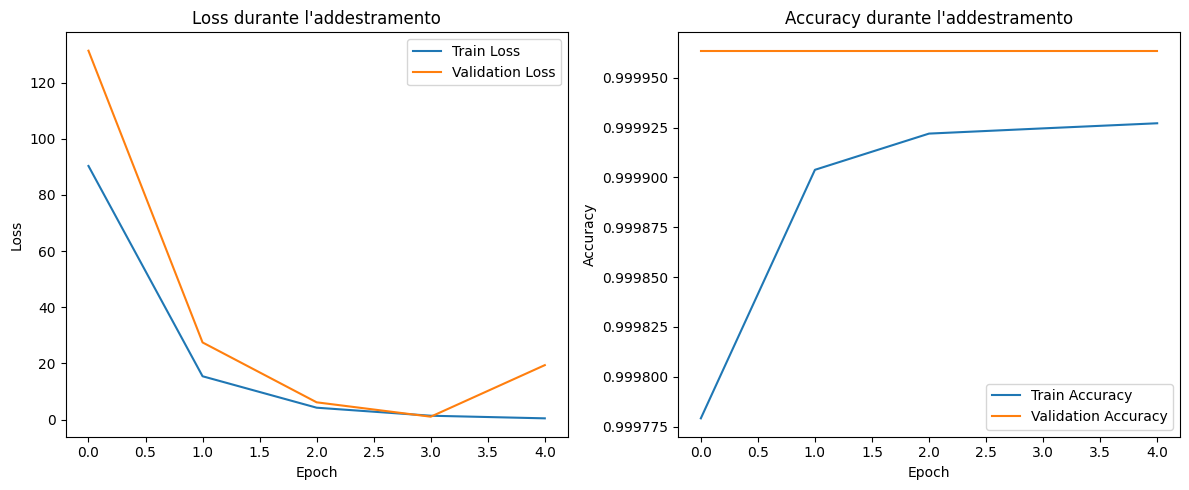

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Funzione per trasformare la colonna Time in una rappresentazione numerica
def transform_time_column(df, time_column):
    try:
        if time_column in df.columns:
            # Gestione flessibile dei formati di data
            df[time_column] = pd.to_datetime(
                df[time_column],
                errors='coerce',
                format='%Y-%m-%d %H:%M:%S.%f'
            )

            # Se alcune date non sono convertite, tenta con un altro formato
            if df[time_column].isna().any():
                df[time_column] = pd.to_datetime(
                    df[time_column].fillna(method='ffill'),
                    errors='coerce',
                    format='%Y-%m-%d'
                )

            if df[time_column].isna().any():
                print("Avviso: alcune date non sono state convertite correttamente e saranno rimosse.")

            # Calcolo dei secondi dall'inizio e rimozione della colonna originale
            df['time_numeric'] = (df[time_column] - df[time_column].min()).dt.total_seconds()
            df = df.drop(columns=[time_column])
            print("Colonna 'Time' trasformata in formato numerico con successo.")
        else:
            print(f"Colonna '{time_column}' non trovata nel dataset.")
        return df
    except Exception as e:
        print(f"Errore durante la trasformazione della colonna 'Time': {e}")
        return df

# Funzione per definire e addestrare il modello DNN
def train_dnn(X_train, y_train, X_val, y_val):
    try:
        input_dim = X_train.shape[1]  # Calcolo della dimensione dell'input

        # Definizione del modello
        model = Sequential([
            Input(shape=(input_dim,)),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])

        # Compilazione del modello
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # Early stopping per evitare overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Addestramento del modello
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=5,  # Ridotto il numero di epoche
            batch_size=32,
            callbacks=[early_stopping]
        )

        print("Modello addestrato con successo.")
        return model, history
    except Exception as e:
        print(f"Errore durante l'addestramento del modello: {e}")
        return None, None

# Funzione per garantire che le feature siano numeriche
def ensure_numeric_features(X):
    try:
        X_numeric = X.select_dtypes(include=[np.number])
        if X_numeric.shape[1] != X.shape[1]:
            print("Avviso: alcune colonne non numeriche sono state rimosse dal dataset.")
        return X_numeric
    except Exception as e:
        print(f"Errore durante la conversione delle feature numeriche: {e}")
        return X

# Funzione per valutare il modello sul test set
def evaluate_model(model, X_test, y_test):
    try:
        # Allineamento delle colonne
        X_test = X_test[X_train.columns]

        y_pred = (model.predict(X_test) > 0.5).astype(int)
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        if len(np.unique(y_test)) > 1:
            auc = roc_auc_score(y_test, y_pred)
            print(f"\nROC-AUC Score: {auc:.4f}")
        else:
            print("\nROC-AUC Score non calcolabile: una sola classe presente in y_test.")
    except Exception as e:
        print(f"Errore durante la valutazione del modello: {e}")

# Funzione per visualizzare loss e accuracy
def plot_training_history(history):
    try:
        # Plot della loss
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss durante l\'addestramento')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot dell'accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy durante l\'addestramento')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Errore durante la visualizzazione della storia dell'addestramento: {e}")

# Funzione per controllare la distribuzione delle classi
def check_class_distribution(y):
    try:
        print("Distribuzione delle classi:")
        print(y.value_counts())
    except Exception as e:
        print(f"Errore durante il controllo della distribuzione delle classi: {e}")

# Esecuzione della pipeline
try:
    # Trasformazione della colonna Time
    X_train = transform_time_column(X_train, time_column='Time')
    X_val = transform_time_column(X_val, time_column='Time')
    X_test = transform_time_column(X_test, time_column='Time')

    # Preprocessing: assicurarsi che le feature siano numeriche
    X_train = ensure_numeric_features(X_train)
    X_val = ensure_numeric_features(X_val)
    X_test = ensure_numeric_features(X_test)

    # Allineamento delle colonne di X_test a quelle di X_train
    X_test = X_test[X_train.columns]

    # Controllo della distribuzione delle classi
    print("Distribuzione delle classi nel test set:")
    check_class_distribution(y_test)

    # Addestramento del modello
    model, history = train_dnn(X_train, y_train, X_val, y_val)

    # Valutazione del modello
    evaluate_model(model, X_test, y_test)

    # Visualizzazione dei grafici di training
    plot_training_history(history)
except Exception as e:
    print(f"Errore durante l'esecuzione della pipeline: {e}")
